In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [1]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
import scipy.io
from pathlib import Path
from tqdm import tqdm
import numcodecs
import random

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/CoNSeP")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data")

# Tile Settings
TILE_SIZE = 512
VAL_SPLIT = 0.10  # 10% for validation
SEED = 42

cv2.setNumThreads(0)
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------
# 1. Helper: Calculate Sliding Coordinates with Edge Overlap
# ---------------------------------------------------------------------
def get_tile_coordinates(dim_size, tile_size):
    """
    Calculates start/end coordinates.
    If the image is 1000 and tile is 512:
    - Tile 1: 0 to 512
    - Tile 2: 488 to 1000 (Force aligns to end)
    """
    coords = []
    
    if dim_size <= tile_size:
        return [(0, tile_size)]

    # Standard sliding
    cursor = 0
    while cursor + tile_size <= dim_size:
        coords.append((cursor, cursor + tile_size))
        cursor += tile_size

    # Handle the remainder by adding a final tile aligned to the edge
    if cursor < dim_size:
        last_start = dim_size - tile_size
        if not coords or coords[-1][0] != last_start:
            coords.append((last_start, dim_size))
            
    return coords

# ---------------------------------------------------------------------
# 2. Process Single CoNSeP Image
# ---------------------------------------------------------------------
def process_single_image(img_path, label_dir, split_name):
    """
    Reads one CoNSeP image and its corresponding .mat label.
    Extracts 512x512 tiles.
    """
    try:
        # A. Load Image
        img = cv2.imread(str(img_path))
        if img is None:
            return []
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (H, W, 3)
        h, w, c = img.shape

        # B. Load Label (.mat)
        # Construct label path: image "train_1.png" -> label "train_1.mat"
        label_path = label_dir / (img_path.stem + ".mat")
        
        if not label_path.exists():
            print(f"⚠️ Label not found: {label_path}")
            return []

        mat = scipy.io.loadmat(str(label_path))
        if 'inst_map' in mat:
            mask = mat['inst_map'].astype(np.int32)
        else:
            print(f"⚠️ Key 'inst_map' not found in {label_path.name}. Keys: {mat.keys()}")
            return []

        # C. Generate Tiling Coordinates
        h_coords = get_tile_coordinates(h, TILE_SIZE)
        w_coords = get_tile_coordinates(w, TILE_SIZE)

        tiles_data = []

        # D. Extract Tiles
        for r_idx, (y_start, y_end) in enumerate(h_coords):
            for c_idx, (x_start, x_end) in enumerate(w_coords):
                
                # Crop Image
                img_crop = img[y_start:y_end, x_start:x_end, :]
                
                # Crop Mask
                mask_crop = mask[y_start:y_end, x_start:x_end]

                metadata = {
                    'original_file': img_path.name,
                    'split': split_name,
                    'tile_index_y': r_idx,
                    'tile_index_x': c_idx,
                    'y_start': y_start,
                    'y_end': y_end,
                    'x_start': x_start,
                    'x_end': x_end,
                    'num_cells': len(np.unique(mask_crop)) - (1 if 0 in mask_crop else 0)
                }

                tiles_data.append({
                    'image': img_crop,
                    'mask': mask_crop,
                    'metadata': metadata
                })

        return tiles_data

    except Exception as e:
        print(f"❌ Error processing {img_path.name}: {e}")
        return []

# ---------------------------------------------------------------------
# 3. Process List of Files (Logic Shared by Train/Val/Test)
# ---------------------------------------------------------------------
def process_file_list(file_list, output_name, label_dir_path):
    """
    file_list: List of Path objects to images
    output_name: e.g., 'consep_train', 'consep_val', 'consep_test'
    label_dir_path: Path object to the Labels folder
    """
    if not file_list:
        print(f"⚠️ No files to process for {output_name}")
        return

    print(f"\n📂 Processing {output_name} ({len(file_list)} slides)...")
    
    results = []
    
    for img_p in tqdm(file_list, desc=output_name):
        file_tiles = process_single_image(img_p, label_dir_path, output_name)
        results.extend(file_tiles)
        
    if not results:
        print(f"⚠️ No tiles extracted for {output_name}")
        return

    # --- Aggregate ---
    print(f"  > Aggregating {len(results)} tiles...")
    all_imgs = np.stack([r['image'] for r in results], axis=0)
    all_masks = np.stack([r['mask'] for r in results], axis=0)
    all_meta = [r['metadata'] for r in results]

    # --- Save Zarr ---
    save_dir = OUTPUT_BASE / output_name
    
    if save_dir.exists():
        import shutil
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)

    print(f"  > Saving Zarr to {save_dir}...")

    # Save Images
    z_img = zarr.open_array(
        str(save_dir / 'images.zarr'),
        mode='w',
        shape=all_imgs.shape,
        chunks=(1, TILE_SIZE, TILE_SIZE, 3),
        dtype='uint8',
        compressor=compressor
    )
    z_img[:] = all_imgs

    # Save Masks
    z_mask = zarr.open_array(
        str(save_dir / 'nuclei_masks.zarr'),
        mode='w',
        shape=all_masks.shape,
        chunks=(1, TILE_SIZE, TILE_SIZE),
        dtype='int32',
        compressor=compressor
    )
    z_mask[:] = all_masks

    # Save Metadata
    pd.DataFrame(all_meta).to_csv(save_dir / 'metadata.csv', index=False)
    
    total_cells = sum(m['num_cells'] for m in all_meta)
    print(f"  ✅ Finished {output_name}: {len(all_imgs)} tiles, ~{total_cells} nuclei.")

# ---------------------------------------------------------------------
# 4. Main Execution
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("="*60)
    print("🔬 CoNSeP Dataset Split: Train(90%) / Val(10%) | Test(Keep As Is)")
    print("="*60)
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

    # --- 1. Process TEST Set (Keep Intact) ---
    test_img_dir = BASE_PATH / "Test" / "Images"
    test_lbl_dir = BASE_PATH / "Test" / "Labels"
    
    if test_img_dir.exists():
        test_files = sorted(list(test_img_dir.glob("*.png")))
        process_file_list(test_files, "consep_test", test_lbl_dir)
    else:
        print("⚠️ Test folder not found.")

    # --- 2. Process TRAIN Set (Split) ---
    train_img_dir = BASE_PATH / "Train" / "Images"
    train_lbl_dir = BASE_PATH / "Train" / "Labels"
    
    if train_img_dir.exists():
        # Gather all source train files
        all_train_files = sorted(list(train_img_dir.glob("*.png")))
        
        # Shuffle & Split
        random.shuffle(all_train_files)
        
        n_val = int(len(all_train_files) * VAL_SPLIT)
        # Ensure at least 1 val image if dataset is small (CoNSeP is small, ~27 train images)
        if n_val == 0 and len(all_train_files) > 1:
            n_val = 1
            
        val_files = all_train_files[:n_val]
        train_files = all_train_files[n_val:]
        
        print(f"\n📊 Split Result for Train Set:")
        print(f"   Training:   {len(train_files)} slides")
        print(f"   Validation: {len(val_files)} slides")
        
        # Process Lists
        process_file_list(train_files, "consep_train", train_lbl_dir)
        process_file_list(val_files, "consep_val", train_lbl_dir)
        
    else:
        print("⚠️ Train folder not found.")

    print("\n✅ ALL DONE")

🔬 CoNSeP Dataset Split: Train(90%) / Val(10%) | Test(Keep As Is)

📂 Processing consep_test (14 slides)...


consep_test: 100%|██████████| 14/14 [00:02<00:00,  6.23it/s]


  > Aggregating 56 tiles...
  > Saving Zarr to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data/consep_test...
  ✅ Finished consep_test: 56 tiles, ~9620 nuclei.

📊 Split Result for Train Set:
   Training:   25 slides
   Validation: 2 slides

📂 Processing consep_train (25 slides)...


consep_train: 100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


  > Aggregating 100 tiles...
  > Saving Zarr to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data/consep_train...
  ✅ Finished consep_train: 100 tiles, ~15585 nuclei.

📂 Processing consep_val (2 slides)...


consep_val: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


  > Aggregating 8 tiles...
  > Saving Zarr to /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data/consep_val...
  ✅ Finished consep_val: 8 tiles, ~1404 nuclei.

✅ ALL DONE


🔬 CoNSeP Dataset Zarr Verification
📂 Base Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data

🔍 Verifying: TRAIN
    Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data/consep_Train
    ✅ Images Shape: (108, 512, 512, 3)
    ✅ Masks Shape:  (108, 512, 512)
    📊 Visualizing samples at indices: [2, 35, 40]...


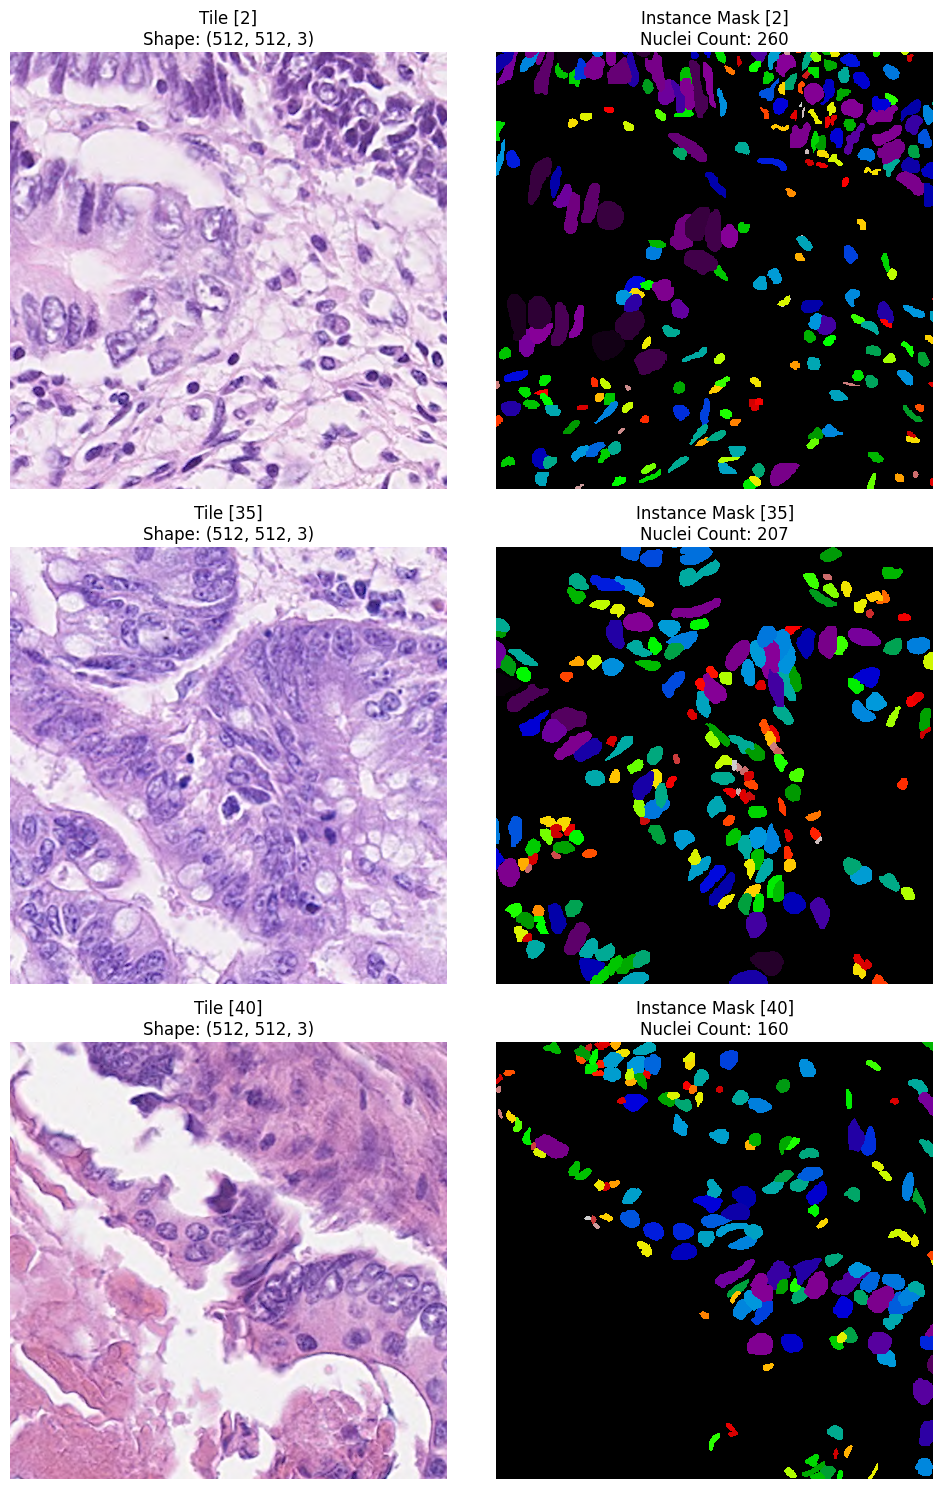


🔍 Verifying: TEST
    Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data/consep_Test
    ✅ Images Shape: (56, 512, 512, 3)
    ✅ Masks Shape:  (56, 512, 512)
    📊 Visualizing samples at indices: [21, 44, 52]...


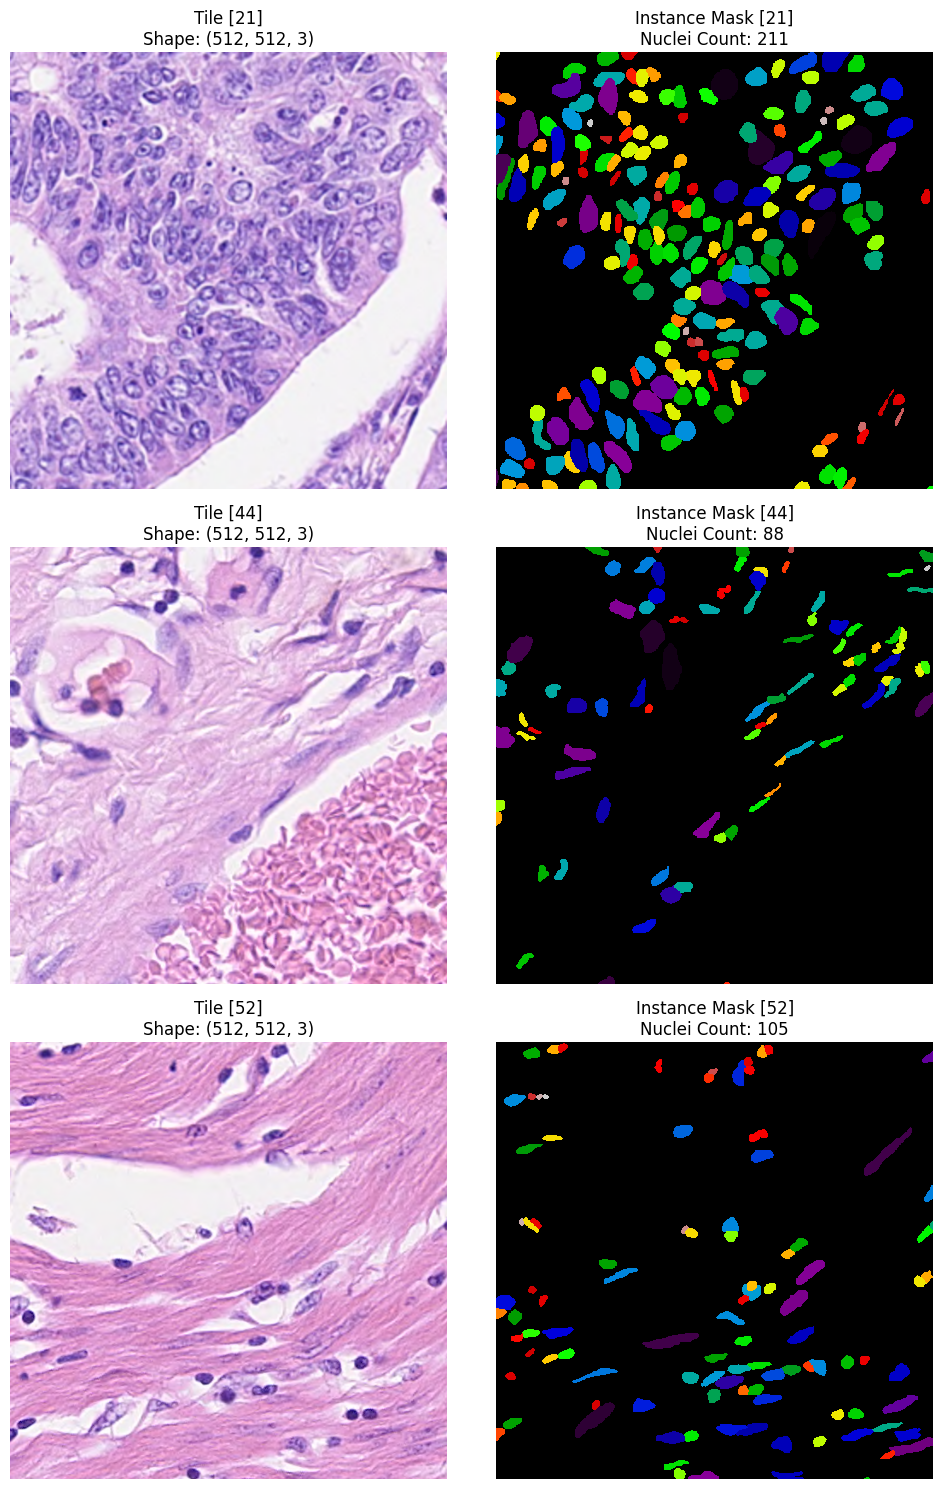


✅ Verification Script Complete


In [5]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

# --- CONFIGURATION ---
# Pointing to the specific CoNSeP output folder you requested
DATA_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/consep/zarr_data")

def verify_dataset(split_name):
    # CoNSeP folders are named 'consep_Train' and 'consep_Test'
    split_dir = DATA_PATH / f"consep_{split_name}"
    
    print(f"\n🔍 Verifying: {split_name.upper()}")
    print(f"    Path: {split_dir}")
    
    if not split_dir.exists():
        print(f"❌ Dataset folder not found: {split_dir}")
        return

    # 1. Open Zarr Arrays (Read-Only)
    try:
        z_img = zarr.open(str(split_dir / 'images.zarr'), mode='r')
        z_mask = zarr.open(str(split_dir / 'nuclei_masks.zarr'), mode='r')
    except Exception as e:
        print(f"❌ Error opening Zarr files: {e}")
        return

    # 2. Print Basic Stats
    num_images = z_img.shape[0]
    print(f"    ✅ Images Shape: {z_img.shape}")
    print(f"    ✅ Masks Shape:  {z_mask.shape}")
    
    if num_images == 0:
        print("⚠️  Dataset is empty.")
        return

    # 3. Visualize Random Samples
    # We pick up to 3 random indices to visualize
    num_samples = 3
    indices = sorted(random.sample(range(num_images), min(num_samples, num_images)))
    
    print(f"    📊 Visualizing samples at indices: {indices}...")

    # Create subplot grid
    # If only 1 sample, we need to make sure axes is iterable
    fig, axes = plt.subplots(len(indices), 2, figsize=(10, 5 * len(indices)))
    if len(indices) == 1:
        axes = np.expand_dims(axes, axis=0) # Make it 2D array-like

    for i, idx in enumerate(indices):
        # Load data from Zarr
        img = z_img[idx]
        mask = z_mask[idx]
        
        # Calculate stats for this specific tile
        unique_ids = np.unique(mask)
        # Subtract 1 for background (0) if present
        num_cells = len(unique_ids) - 1 if 0 in unique_ids else len(unique_ids)
        
        # --- Plot Image ---
        ax_img = axes[i][0]
        ax_img.imshow(img)
        ax_img.set_title(f"Tile [{idx}]\nShape: {img.shape}")
        ax_img.axis('off')
        
        # --- Plot Mask ---
        ax_mask = axes[i][1]
        
        # Create a masked array where 0 (background) is transparent or specific color
        masked_data = np.ma.masked_where(mask == 0, mask)
        
        # Use a high-contrast colormap (nipy_spectral) to see individual instances
        cmap = plt.cm.nipy_spectral
        cmap.set_bad(color='black') # Background color
        
        ax_mask.imshow(masked_data, cmap=cmap, interpolation='nearest')
        ax_mask.set_title(f"Instance Mask [{idx}]\nNuclei Count: {num_cells}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("="*60)
    print("🔬 CoNSeP Dataset Zarr Verification")
    print(f"📂 Base Path: {DATA_PATH}")
    print("="*60)
    
    # 1. Check Train
    verify_dataset("Train")
    
    # 2. Check Test
    verify_dataset("Test")
    
    print("\n✅ Verification Script Complete")